# BitFEAR: Time Series Analysis

Experimental analysis and learning using:

* Tweets containing #bitcoin, with Vader sentiment scores
* Tweet volume for #bitcoin
* Google Trends data
* Deribit Bitcoin Options orderbook data
* Bitcoin price data

In [360]:
%config IPCompleter.greedy=True

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (16, 10)

### Getting tweets from Google Cloud Storage

In [3]:
from google.cloud import firestore
import json

In [4]:
db = firestore.Client()
tweets_ref = db.collection('tweet_data_#bitcoin')

tweets = list()
tweet_docs = list()
#for doc in tweets_ref.stream():
#    tweets.append(doc.to_dict())
    
def count_collection(coll_ref, count, cursor=None):

    if cursor is not None:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").start_after(cursor).stream()]
    else:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").stream()]

    count = count + len(docs)
    tweet_docs.append(docs)

    if len(docs) == 1000:
        return count_collection(coll_ref, count, docs[999].reference.get())
    else:
        print(count)

In [5]:
# ONLY RUN THIS CELL TO RETREIVE TWEETS FROM THE BEGINNING (EXPENSIVE!)

count_collection(tweets_ref, 0)
last_tweet = tweet_docs[-1][-1].reference.get()

311631


In [521]:
# Get tweets since last retreival

count_collection(tweets_ref, 0, last_tweet)
last_tweet = tweet_docs[-1][-1].reference.get()

32350


In [6]:
tweets += [item.to_dict() for sublist in tweet_docs for item in sublist]

In [7]:
tweets_df = pd.DataFrame(tweets)
tweets_df['compound'] = pd.json_normalize(tweets_df['sentiment_scores'])['compound']
tweets_df = tweets_df.filter(['created', 'tweet_id', 'user_id', 'compound'])

In [8]:
tweets_df = tweets_df.drop_duplicates().reset_index(drop=True)
tweets_df

,created,tweet_id,user_id,compound
0,2020-03-09 19:43:06+00:00,1237101627925987329,116270443,0.0000
1,2020-03-09 19:43:20+00:00,1237101685757087744,2372242398,0.4926
2,2020-03-09 19:43:26+00:00,1237101710935392256,1075804135524585473,0.4926
3,2020-03-09 19:43:30+00:00,1237101728488718336,877210351301001216,0.0000
4,2020-03-09 19:43:32+00:00,1237101736650661888,1153377427034259457,0.4019
...,...,...,...,...
311626,2020-04-28 15:36:16+00:00,1255158899797372928,1209613458989355008,0.3612
311627,2020-04-28 15:36:32+00:00,1255158968080429057,3218692340,0.0000
311628,2020-04-28 15:36:34+00:00,1255158975957532675,1202255032525238277,0.8176
311629,2020-04-28 15:36:43+00:00,1255159014784225281,1026426791660011521,0.0000


### Calculate tweet volume

In [9]:
tweets_time_df = tweets_df.set_index('created').filter(['tweet_id', 'compound'])
tweets_time_df

,tweet_id,compound
created,,
2020-03-09 19:43:06+00:00,1237101627925987329,0.0000
2020-03-09 19:43:20+00:00,1237101685757087744,0.4926
2020-03-09 19:43:26+00:00,1237101710935392256,0.4926
2020-03-09 19:43:30+00:00,1237101728488718336,0.0000
2020-03-09 19:43:32+00:00,1237101736650661888,0.4019
...,...,...
2020-04-28 15:36:16+00:00,1255158899797372928,0.3612
2020-04-28 15:36:32+00:00,1255158968080429057,0.0000
2020-04-28 15:36:34+00:00,1255158975957532675,0.8176


In [10]:
tweet_grouped = tweets_time_df.groupby(pd.Grouper(freq='5Min'))
tweet_volume = tweet_grouped.count()
tweet_volume

,tweet_id,compound
created,,
2020-03-09 19:40:00+00:00,13,13
2020-03-09 19:45:00+00:00,29,29
2020-03-09 19:50:00+00:00,30,30
2020-03-09 19:55:00+00:00,40,40
2020-03-09 20:00:00+00:00,40,40
...,...,...
2020-04-28 15:15:00+00:00,30,30
2020-04-28 15:20:00+00:00,25,25
2020-04-28 15:25:00+00:00,22,22


Text(0.5, 1.0, '#bitcoin Tweets per 5 min')

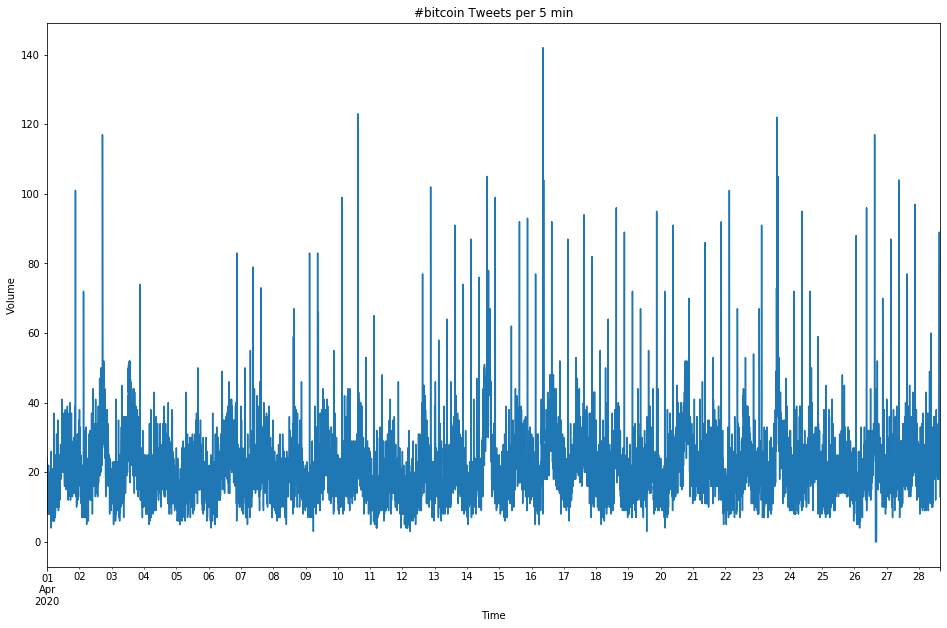

In [11]:
plot_start_date = '2020-04-01'

ax = tweet_volume['tweet_id'].loc[plot_start_date:].plot()
ax.set_xlabel('Time')
ax.set_ylabel('Volume')
ax.set_title('#bitcoin Tweets per 5 min')

Investigate the spikes:

In [12]:
tweet_volume.sort_values(by='tweet_id')

,tweet_id,compound
created,,
2020-03-10 23:20:00+00:00,0,0
2020-03-10 22:55:00+00:00,0,0
2020-03-11 00:15:00+00:00,0,0
2020-03-10 22:50:00+00:00,0,0
2020-03-10 22:45:00+00:00,0,0
...,...,...
2020-03-12 10:45:00+00:00,134,134
2020-03-13 00:00:00+00:00,142,142
2020-04-16 08:30:00+00:00,142,142


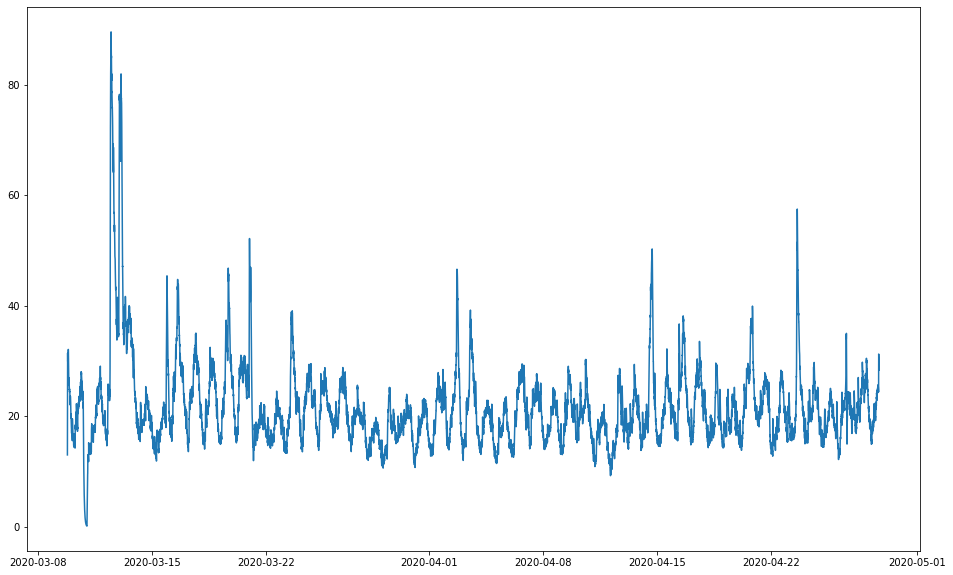

In [13]:
tweet_volume['smooth'] = tweet_volume['tweet_id'].ewm(12).mean()
plt.plot(tweet_volume['smooth'])

### Tweet sentiment time series

In [14]:
sentiment_time = tweet_grouped.mean()
sentiment_time

,compound
created,
2020-03-09 19:40:00+00:00,0.261085
2020-03-09 19:45:00+00:00,0.194479
2020-03-09 19:50:00+00:00,0.176573
2020-03-09 19:55:00+00:00,0.081617
2020-03-09 20:00:00+00:00,0.050008
...,...
2020-04-28 15:15:00+00:00,0.256830
2020-04-28 15:20:00+00:00,0.056048
2020-04-28 15:25:00+00:00,0.213032


Text(0, 0.5, 'Mean Sentiment Rating')

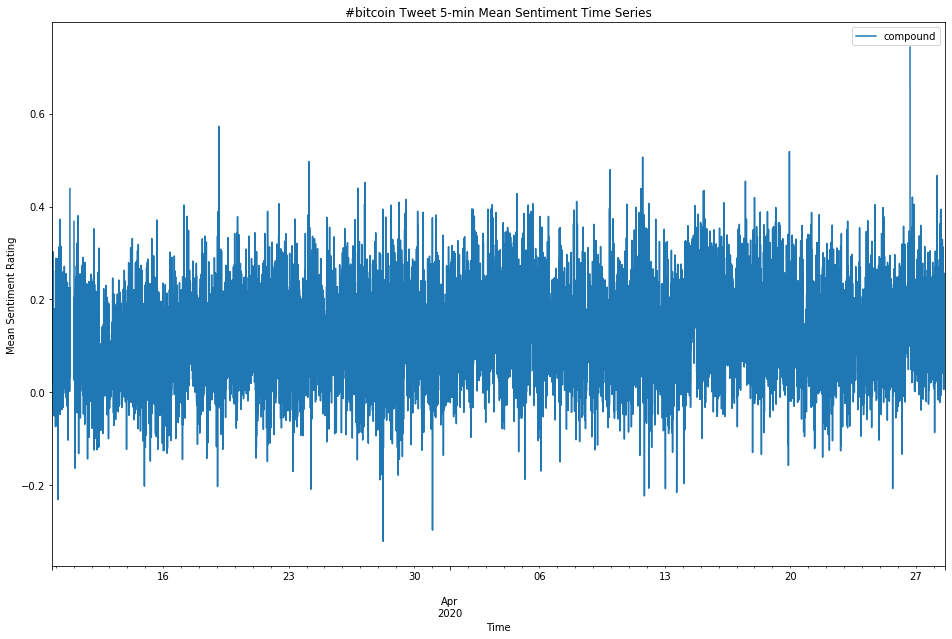

In [15]:
sentiment_time.plot()
plt.title('#bitcoin Tweet 5-min Mean Sentiment Time Series')
plt.xlabel('Time')
plt.ylabel('Mean Sentiment Rating')

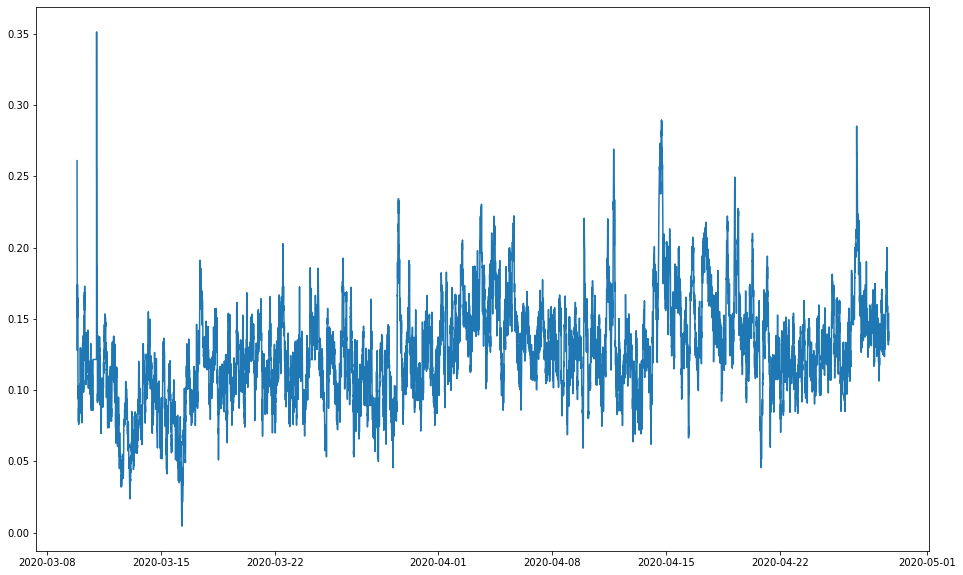

In [16]:
sentiment_time['smooth'] = sentiment_time['compound'].ewm(12).mean()
plt.plot(sentiment_time['smooth'])

### Google Trends Data

In [17]:
from pytrends.request import TrendReq

In [18]:
focus_words = ['bitcoin']

pygt = TrendReq()
pygt.build_payload(kw_list=focus_words)

interest_over_time_df = pygt.interest_over_time()
del interest_over_time_df['isPartial']
interest_over_time_df

,bitcoin
date,
2015-05-03,2
2015-05-10,2
2015-05-17,2
2015-05-24,2
2015-05-31,2
...,...
2020-03-22,15
2020-03-29,13
2020-04-05,13


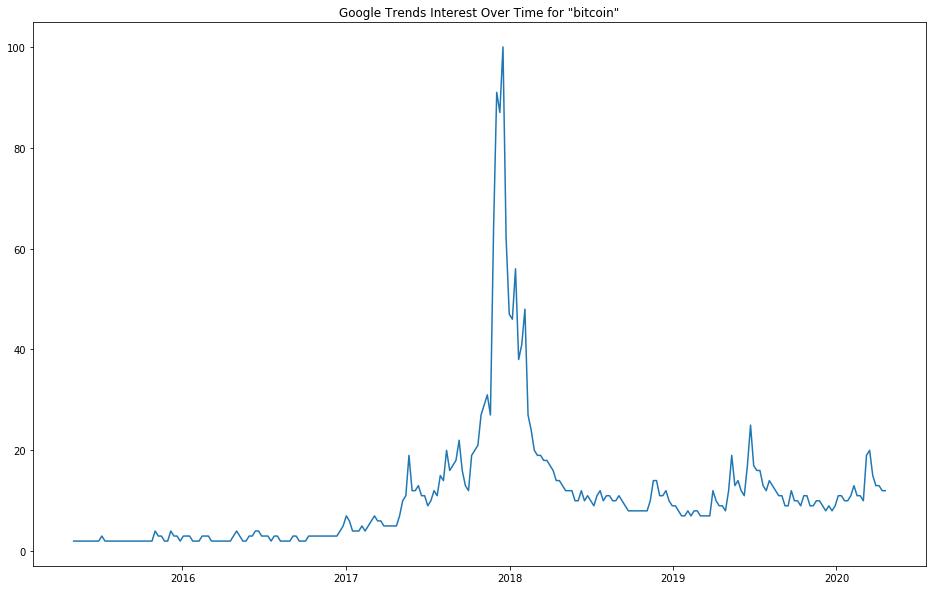

In [19]:
plot = plt.plot(interest_over_time_df)
plt.title('Google Trends Interest Over Time for "bitcoin"')
plt.show()

In [38]:
historical_hourly_interest_df = pygt.get_historical_interest(focus_words, year_start=2020, month_start=4, day_start=18, hour_start=0, year_end=2020, month_end=4, day_end=28, hour_end=16, cat=0, geo='', gprop='').drop('isPartial', axis=1).reset_index().drop_duplicates('date').set_index('date')
historical_hourly_interest_df

,bitcoin
date,
2020-04-18 00:00:00,77
2020-04-18 01:00:00,69
2020-04-18 02:00:00,66
2020-04-18 03:00:00,65
2020-04-18 04:00:00,69
...,...
2020-04-28 11:00:00,85
2020-04-28 12:00:00,83
2020-04-28 13:00:00,88


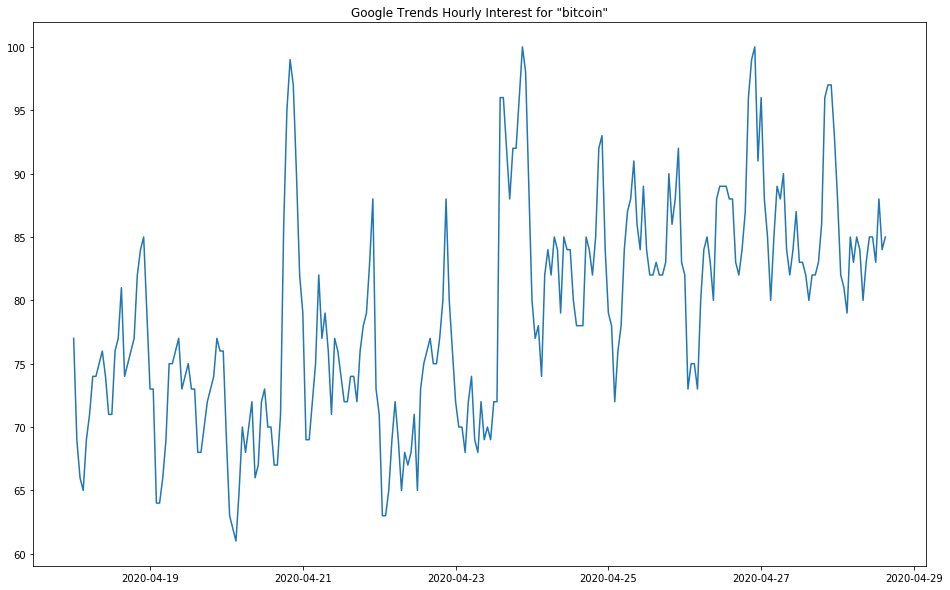

In [39]:
plot = plt.plot(historical_hourly_interest_df)
plt.title('Google Trends Hourly Interest for "bitcoin"')
plt.show()

Some issues with this data.

Upsample with linear interpolation to five minute intervals to match other data series.

In [40]:
gtrend_5min_df = pd.DataFrame(historical_hourly_interest_df.bitcoin.resample('5min').interpolate(method='linear'))
gtrend_5min_df.index = gtrend_5min_df.index.tz_localize('UTC')
gtrend_5min_df

,bitcoin
date,
2020-04-18 00:00:00+00:00,77.000000
2020-04-18 00:05:00+00:00,76.333333
2020-04-18 00:10:00+00:00,75.666667
2020-04-18 00:15:00+00:00,75.000000
2020-04-18 00:20:00+00:00,74.333333
...,...
2020-04-28 14:40:00+00:00,84.666667
2020-04-28 14:45:00+00:00,84.750000
2020-04-28 14:50:00+00:00,84.833333


### Bitcoin price index data

In [25]:
import requests
from io import StringIO

In [26]:
btc_index_dbit_data = requests.get('https://www.deribit.com/static/csv/2020-04_btc_usd_price_index.csv').content.decode()

In [27]:
btc_index_dbit_df = pd.read_csv(StringIO(btc_index_dbit_data), skiprows=1)
btc_index_dbit_df['Date and Time'] = pd.to_datetime(btc_index_dbit_df['Date and Time'], format='%Y-%m-%d %H:%M:%S')
btc_index_dbit_df = btc_index_dbit_df.set_index('Date and Time').tz_localize('UTC', level=0)
btc_index_dbit_df

,Price
Date and Time,
2020-04-01 00:00:00+00:00,6423.38
2020-04-01 00:00:01+00:00,6423.79
2020-04-01 00:00:02+00:00,6423.72
2020-04-01 00:00:03+00:00,6423.88
2020-04-01 00:00:04+00:00,6424.28
...,...
2020-04-28 15:43:13+00:00,7717.02
2020-04-28 15:43:14+00:00,7717.02
2020-04-28 15:43:15+00:00,7716.92


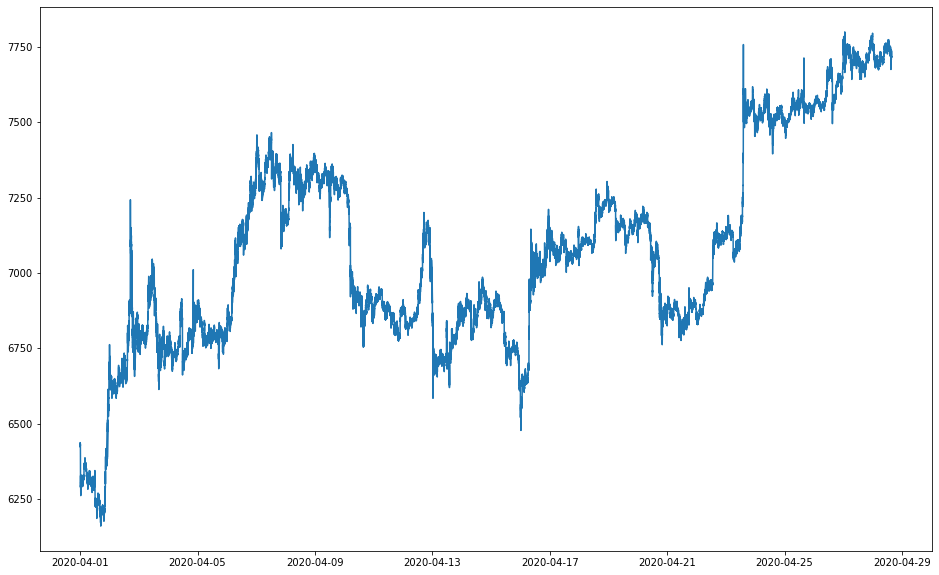

In [28]:
plt.plot(btc_index_dbit_df)

### Volatility index data

In [51]:
indices_df = pd.read_csv('/home/fp361/bitfear/vix-implementation/volatility_data.csv')
indices_df['timestamp'] = pd.to_datetime(indices_df['timestamp'])
indices_df = indices_df.set_index('timestamp').tz_localize('UTC', level=0)
indices_df

,vxbt,gvxbt,avxbt
timestamp,,,
2020-04-17 08:35:00+00:00,1.043923,0.796232,0.000114
2020-04-17 08:40:00+00:00,1.043290,0.796363,0.000114
2020-04-17 08:45:00+00:00,1.044881,0.791626,0.000113
2020-04-17 08:50:00+00:00,1.041748,0.799744,0.000114
2020-04-17 08:55:00+00:00,1.034267,0.803266,0.000115
...,...,...,...
2020-04-28 17:45:00+00:00,0.830799,0.803397,0.000104
2020-04-28 17:46:00+00:00,0.829567,0.801876,0.000103
2020-04-28 17:47:00+00:00,0.828961,0.800835,0.000103


***

## Regression Models

### Data Cleaning

Select a common time range where each series has clean data available:

In [52]:
start_date = max([df.index[0] for df in [btc_index_dbit_df, sentiment_time, tweet_volume, indices_df, gtrend_5min_df]])
end_date = min([df.index[-1] for df in [btc_index_dbit_df, sentiment_time, tweet_volume, indices_df, gtrend_5min_df]])

print(f'Start: {start_date}')
print(f'End: {end_date}')

series_btc = btc_index_dbit_df.loc[start_date:end_date]
series_sentiment = sentiment_time['smooth'].loc[start_date:end_date]
series_volume = tweet_volume.filter(['smooth']).loc[start_date:end_date]
series_indices = indices_df['vxbt'].loc[start_date:end_date]
series_gtrend = gtrend_5min_df['bitcoin'].loc[start_date:end_date]

Start: 2020-04-18 00:00:00+00:00
End: 2020-04-28 15:00:00+00:00


In [53]:
series_sentiment

created
2020-04-18 00:00:00+00:00    0.136302
2020-04-18 00:05:00+00:00    0.158080
2020-04-18 00:10:00+00:00    0.144090
2020-04-18 00:15:00+00:00    0.147941
2020-04-18 00:20:00+00:00    0.156821
                               ...   
2020-04-28 14:40:00+00:00    0.141447
2020-04-28 14:45:00+00:00    0.147313
2020-04-28 14:50:00+00:00    0.145594
2020-04-28 14:55:00+00:00    0.147584
2020-04-28 15:00:00+00:00    0.146065
Freq: 5T, Name: smooth, Length: 3061, dtype: float64

Plot narrowed down time series:

Text(0.5, 0.98, 'Time Series')

/home/fp361/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


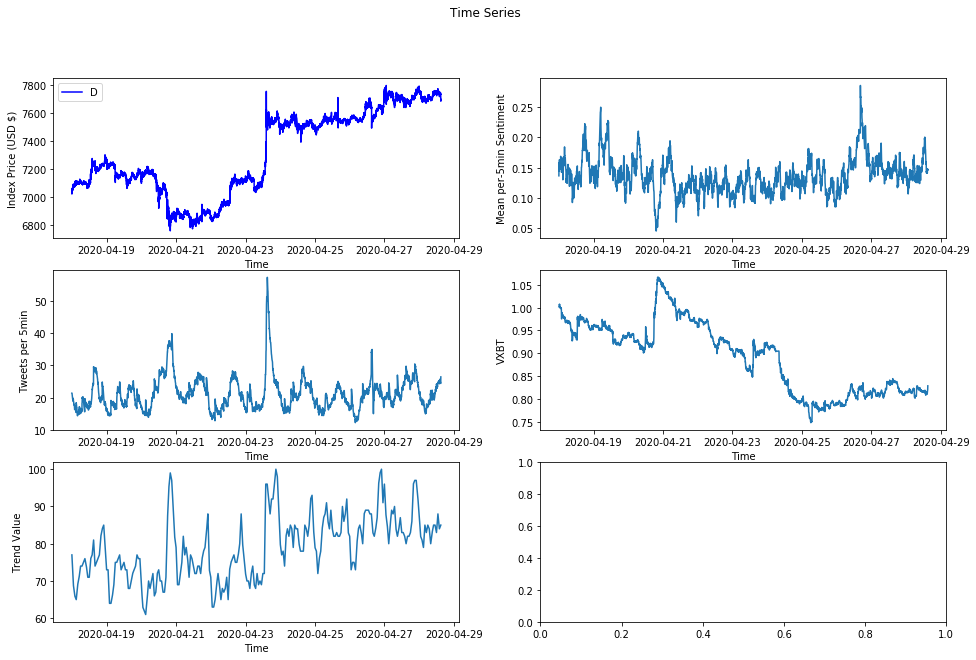

In [54]:
fig, ax =  plt.subplots(3,2)

ax[0][0].plot(series_btc, color='blue')
ax[0][0].legend('Deribit')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Index Price (USD $)')

ax[0][1].plot(series_sentiment)
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('Mean per-5min Sentiment')

ax[1][0].plot(series_volume)
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Tweets per 5min')

ax[1][1].plot(series_indices)
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('VXBT')

ax[2][0].plot(series_gtrend)
ax[2][0].set_xlabel('Time')
ax[2][0].set_ylabel('Trend Value')

fig.suptitle('Time Series')

Discard Google Trends data for the time being. Need to determine what is causing the strange gaps.

In [55]:
data = pd.DataFrame(series_indices).merge(series_volume, left_index=True, right_index=True).merge(series_sentiment, left_index=True, right_index=True).merge(series_gtrend, left_index=True, right_index=True).merge(series_btc, left_index=True, right_index=True).dropna()
#data = pd.DataFrame(series_indices).merge(series_volume, left_index=True, right_index=True).merge(series_sentiment, left_index=True, right_index=True).merge(series_btc, left_index=True, right_index=True).dropna()
data.columns = ['vxbt', 'tweet_vol', 'sentiment', 'gtrend', 'index']
#data.columns = ['vxbt', 'tweet_vol', 'sentiment', 'index']
data = data.sort_index(ascending=False)
data

,vxbt,tweet_vol,sentiment,gtrend,index
2020-04-28 15:00:00+00:00,0.828598,26.437343,0.146065,85.000000,7690.49
2020-04-28 14:55:00+00:00,0.819606,24.390455,0.147584,84.916667,7729.17
2020-04-28 14:50:00+00:00,0.819002,24.422993,0.145594,84.833333,7739.45
2020-04-28 14:45:00+00:00,0.817476,24.708242,0.147313,84.750000,7733.24
2020-04-28 14:40:00+00:00,0.813475,24.933929,0.141447,84.666667,7749.36
...,...,...,...,...,...
2020-04-18 00:20:00+00:00,1.005361,20.188309,0.156821,74.333333,7064.80
2020-04-18 00:15:00+00:00,1.005483,20.787334,0.147941,75.000000,7061.62
2020-04-18 00:10:00+00:00,1.004233,20.936279,0.144090,75.666667,7053.61
2020-04-18 00:05:00+00:00,1.002308,21.347636,0.158080,76.333333,7050.19


In [56]:
data.to_csv('data.csv')

### Linear Regression

In [57]:
samples_in_window = 10
X = []
y = []

for i in range(1, data.shape[0] - samples_in_window):
    X.append(data.iloc[i:i + samples_in_window, :].to_numpy().ravel())
    
y = data['index'].iloc[0:data.shape[0] - samples_in_window - 1]

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg = linreg.fit(X, y)

In [100]:
print(linreg.intercept_)

feature_names = [f'{data.columns[i % len(data.columns)]},t-{i//len(data.columns)+1}' for i, coeff in enumerate(linreg.coef_)]
print(json.dumps(dict(zip(feature_names, linreg.coef_)), indent=1))

27.74531002697131
{
 "vxbt,t-1": -192.44924053820503,
 "tweet_vol,t-1": 0.31372053912518466,
 "sentiment,t-1": 1.735142123275893,
 "gtrend,t-1": -1.3608678486014458,
 "index,t-1": 0.9067176108657566,
 "vxbt,t-2": 209.6936851601251,
 "tweet_vol,t-2": -1.1833173931460301,
 "sentiment,t-2": 10.399562464556844,
 "gtrend,t-2": 1.0193045720815164,
 "index,t-2": 0.0797934481651339,
 "vxbt,t-3": -127.88815618254984,
 "tweet_vol,t-3": 1.0534339442130367,
 "sentiment,t-3": 15.569331387896973,
 "gtrend,t-3": 1.9288282201303186,
 "index,t-3": 0.06370618354987556,
 "vxbt,t-4": 286.76592520238205,
 "tweet_vol,t-4": 0.6016213688885017,
 "sentiment,t-4": 20.155412126778906,
 "gtrend,t-4": -6.487370426610607,
 "index,t-4": -0.0770512422227938,
 "vxbt,t-5": -127.73896045277934,
 "tweet_vol,t-5": -0.41861990429883633,
 "sentiment,t-5": -46.311728009806814,
 "gtrend,t-5": 12.987261180465723,
 "index,t-5": 0.020317278727180366,
 "vxbt,t-6": -206.89705408399843,
 "tweet_vol,t-6": -0.31103559266082215,
 "sen

#### Metrics

In [60]:
from sklearn import metrics

pred = pd.DataFrame(index=data.iloc[0:len(y)].index)
pred['val'] = linreg.predict(X)

print('RMSE {}'.format(np.sqrt(metrics.mean_squared_error(data['index'].iloc[0:len(y)], pred['val']))))

RMSE 10.769106753424413


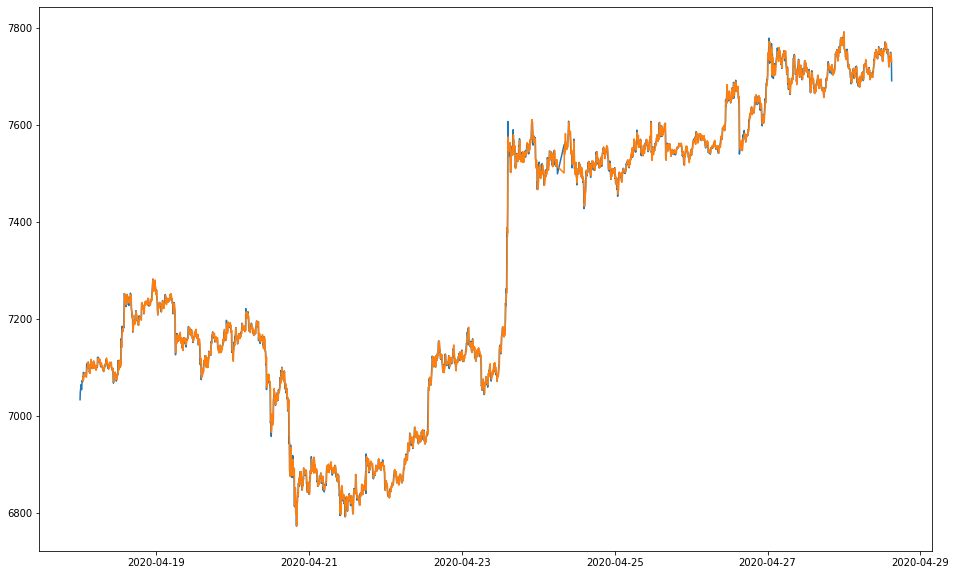

In [61]:
plt.plot(data['index'])
plt.plot(pred)

### Permutation Importance

In [62]:
from sklearn.inspection import permutation_importance

In [108]:
importances = permutation_importance(linreg, X, y)

importances_mean = dict(zip(feature_names, importances['importances_mean']))
sorted_im_mean = {k: v for k, v in sorted(importances_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_mean, indent=1))

{
 "index,t-1": 1.647439059368764,
 "gtrend,t-5": 0.2735923708069359,
 "gtrend,t-6": 0.12806014381037759,
 "gtrend,t-4": 0.06827127940039171,
 "gtrend,t-8": 0.017647083150634724,
 "index,t-8": 0.014759545176495803,
 "index,t-2": 0.012757405364698004,
 "index,t-4": 0.011887369667432424,
 "vxbt,t-4": 0.010879688374026331,
 "index,t-3": 0.00813446629856307,
 "index,t-7": 0.007187796563692284,
 "gtrend,t-3": 0.006022553137706943,
 "vxbt,t-2": 0.005804736776427654,
 "vxbt,t-6": 0.005706946282777769,
 "gtrend,t-7": 0.005015850950089007,
 "vxbt,t-1": 0.004923099123795138,
 "gtrend,t-10": 0.004094438747992068,
 "index,t-9": 0.0037777488033681195,
 "gtrend,t-1": 0.0030059867875799283,
 "vxbt,t-3": 0.002181841028448406,
 "vxbt,t-5": 0.002180966567452214,
 "index,t-6": 0.001997154647761268,
 "gtrend,t-2": 0.001680372577119882,
 "gtrend,t-9": 0.0012998009839696235,
 "tweet_vol,t-2": 0.0008687215840952111,
 "index,t-5": 0.0008279085011008158,
 "tweet_vol,t-3": 0.0006798670784509131,
 "vxbt,t-8": 0.

### ARIMA

With reference to:

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.ethanrosenthal.com/2018/03/22/time-series-for-scikit-learn-people-part2/

In [198]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [220]:
vals = data['index']

train = vals[:int(0.7*(len(vals)))]
valid = vals[int(0.7*(len(vals))):]

model = pm.auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=4844.160, BIC=4871.194, Time=1.135 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=4850.562, BIC=4859.574, Time=0.026 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=4851.841, BIC=4865.358, Time=0.079 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=4851.811, BIC=4865.329, Time=0.115 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=4848.619, BIC=4853.125, Time=0.018 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=4851.684, BIC=4874.213, Time=0.557 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=4851.423, BIC=4873.952, Time=0.392 seconds
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=4855.399, BIC=4886.939, Time=0.585 seconds
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=4846.141, BIC=4877.682, Time=0.750 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=4853.551, BIC=4871.

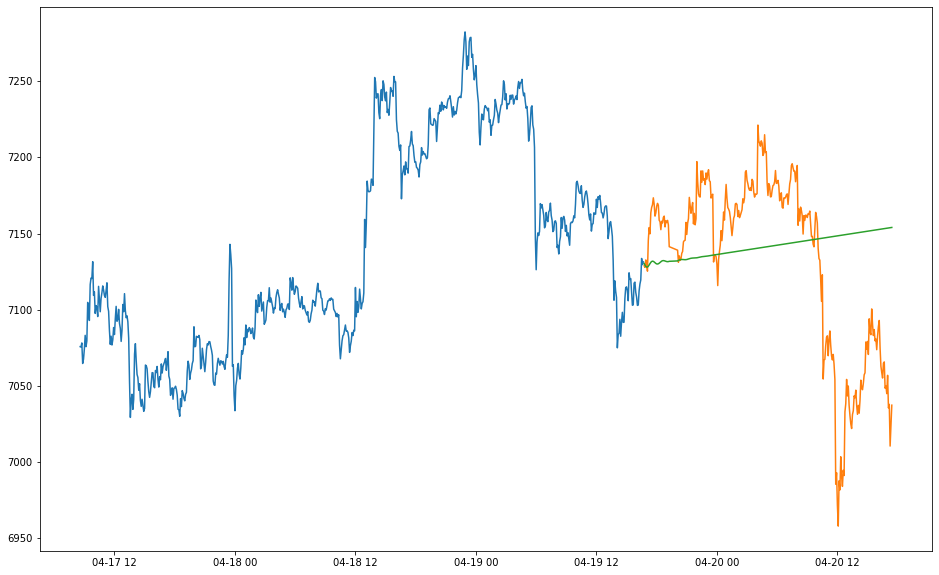

In [221]:
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()